In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, auc, confusion_matrix, accuracy_score, precision_score, roc_curve
from sklearn.model_selection import train_test_split
from copy import copy



# Statistical Learning, Lab #1: Classification
## The Stock Market Data

We start putting in practice the concepts learned during the lessons by
looking at the `Smarket` data, part of the `ISLR2` library.
The data set contains percentage returns for the S&P 500 stock index over 1,250 days (_observations_),
from 2001 to 2005. Each observation is characterized by a number of _predictors_:
`Lag1` to `Lag5` (percentage returns for the five previous days),
`Volume` (the number of shares traded on the previous day),
`Today` (percentage return on that date),
`Direction` (whether the market was Up or Down on that date).


In [49]:

Smarket = pd.read_csv("Smarket.csv", index_col=0)

"It is always good to literally look at the data."

In [50]:
print(Smarket)
print(Smarket.describe())

      Year   Lag1   Lag2   Lag3   Lag4   Lag5   Volume  Today Direction
1     2001  0.381 -0.192 -2.624 -1.055  5.010  1.19130  0.959        Up
2     2001  0.959  0.381 -0.192 -2.624 -1.055  1.29650  1.032        Up
3     2001  1.032  0.959  0.381 -0.192 -2.624  1.41120 -0.623      Down
4     2001 -0.623  1.032  0.959  0.381 -0.192  1.27600  0.614        Up
5     2001  0.614 -0.623  1.032  0.959  0.381  1.20570  0.213        Up
...    ...    ...    ...    ...    ...    ...      ...    ...       ...
1246  2005  0.422  0.252 -0.024 -0.584 -0.285  1.88850  0.043        Up
1247  2005  0.043  0.422  0.252 -0.024 -0.584  1.28581 -0.955      Down
1248  2005 -0.955  0.043  0.422  0.252 -0.024  1.54047  0.130        Up
1249  2005  0.130 -0.955  0.043  0.422  0.252  1.42236 -0.298      Down
1250  2005 -0.298  0.130 -0.955  0.043  0.422  1.38254 -0.489      Down

[1250 rows x 9 columns]
              Year         Lag1         Lag2         Lag3         Lag4  \
count  1250.000000  1250.000000  1250

**Hint:** for convenience, we can copy the `Smarket` dataframe to a new variable with a shorter name,
and then forget about the `Smarket` object. Most importantly, we can modify the dataframe stored
in the new variable knowing that if we mess up we can copy `Smarket` over and start again.

In [51]:
dataf = copy(Smarket)

## Data exploration

One of the first things to do is to explore the relationships between the variables.
We can do that quickly using the plotting.scatter_matrix function, which produces a scatterplot matrix:

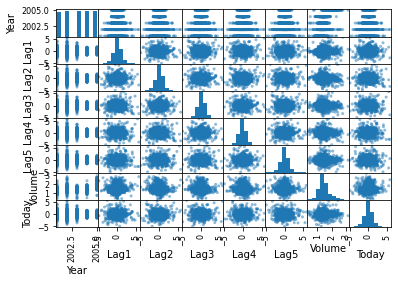

In [52]:
pd.plotting.scatter_matrix(dataf)
plt.show()

This gives us a rough, qualitative idea. Let's quantify by computing pairwise correlations:

In [53]:
print(dataf.corr())

            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000  0.029700  0.030596  0.033195  0.035689  0.029788  0.539006   
Lag1    0.029700  1.000000 -0.026294 -0.010803 -0.002986 -0.005675  0.040910   
Lag2    0.030596 -0.026294  1.000000 -0.025897 -0.010854 -0.003558 -0.043383   
Lag3    0.033195 -0.010803 -0.025897  1.000000 -0.024051 -0.018808 -0.041824   
Lag4    0.035689 -0.002986 -0.010854 -0.024051  1.000000 -0.027084 -0.048414   
Lag5    0.029788 -0.005675 -0.003558 -0.018808 -0.027084  1.000000 -0.022002   
Volume  0.539006  0.040910 -0.043383 -0.041824 -0.048414 -0.022002  1.000000   
Today   0.030095 -0.026155 -0.010250 -0.002448 -0.006900 -0.034860  0.014592   

           Today  
Year    0.030095  
Lag1   -0.026155  
Lag2   -0.010250  
Lag3   -0.002448  
Lag4   -0.006900  
Lag5   -0.034860  
Volume  0.014592  
Today   1.000000  


By looking at the matrix, we see that the correlations are mostly close to zero,
except for those between `Year` and `Volume`.

Now let's have a look at the Volume variable, by plotting its values:

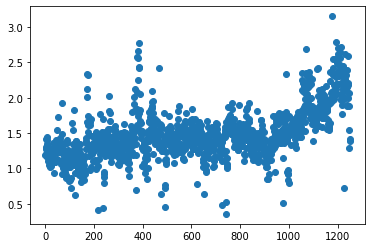

In [54]:
plt.scatter(dataf.index,dataf["Volume"])
plt.show()

"What if we wanted to plot the Volume values by year?"

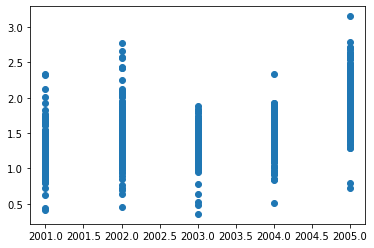

In [55]:
plt.scatter(dataf["Year"], dataf["Volume"])
plt.show()

Probably not the smartest idea. Let's try to make this plot more informative: 
for example, we can plot the *mean* Volume by year. 
A quick way to do this is using the `aggregate` function:

In [56]:

Volume_means = dataf.drop("Direction",axis=1).groupby("Year").aggregate(pd.DataFrame.mean)["Volume"]
print(Volume_means)

Year
2001    1.226950
2002    1.428451
2003    1.384693
2004    1.424159
2005    1.917298
Name: Volume, dtype: float64


(**Hint:** get used to look at the contents of a newly created object,
like I did above by typing `Volume_means`. This allows you to detect potential errors in advance!)

Now, let's plot the aggregated volumes:

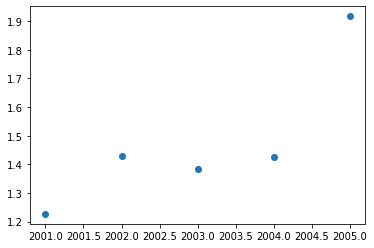

In [57]:
plt.scatter(Volume_means.index,Volume_means)
plt.show()

What if we still wanted to plot all `Volume` values by year? 
Here is a solution using *transparency*

(Editor's note: do not use jittering, you are literally modifying your original data)

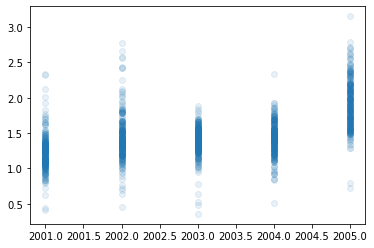

In [58]:
plt.scatter(dataf["Year"], dataf["Volume"], alpha= 0.1)
plt.show()

## Logistic Regression

### Fitting a model

We now want to predict the `Direction` target variable using a multivariate Logistic Regression model with
`Lag1`-`Lag5` and `Volume` as predictors.

Let's set up the logistic regression model:

In [59]:
predictors = dataf[["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]]
glm_fits = LogisticRegression()
glm_fits.fit(predictors, dataf["Direction"])

print("\nCoefficients:")
print(pd.Series(glm_fits.coef_[0], index=["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]))
print("\nintercept:",glm_fits.intercept_[0])


Coefficients:
Lag1     -0.072843
Lag2     -0.042235
Lag3      0.011016
Lag4      0.009284
Lag5      0.010264
Volume    0.132112
dtype: float64

intercept: -0.12108463339290455


### Getting predictions

Predictions are done using the `predict_proba()` function:

In [60]:
prediction_probs = glm_fits.predict_proba(predictors)
print("\nPredicted probabilities of the first 10 elements:")
print(prediction_probs[:10])


Predicted probabilities of the first 10 elements:
[[0.49265655 0.50734345]
 [0.51825557 0.48174443]
 [0.51870199 0.48129801]
 [0.48465057 0.51534943]
 [0.48900868 0.51099132]
 [0.49293516 0.50706484]
 [0.50725062 0.49274938]
 [0.49072089 0.50927911]
 [0.48216707 0.51783293]
 [0.51090531 0.48909469]]


We want actual labels instead of probabilities (and we are using our standard 0.5 threshold):

In [61]:
predictions = pd.Series(glm_fits.predict(predictors))
print("\nFirst 10 predictions:")
print(predictions[:10])


First 10 predictions:
0      Up
1    Down
2    Down
3      Up
4      Up
5      Up
6    Down
7      Up
8      Up
9    Down
dtype: object


Now we can build our confusion matrix and compute our first metrics,
i.e. the number of correct predictions / total observations (the accuracy),
or the prediction error.

In [62]:

print("\nConfusion matrix:\n", confusion_matrix(predictions,dataf["Direction"]))
print("\nAccuracy:", accuracy_score(predictions,dataf["Direction"]))


Confusion matrix:
 [[144 141]
 [458 507]]

Accuracy: 0.5208


Remember that so far we have been talking about the *training* performance!
We trained and tested the model on the same set of observations. 

In order to obtain a better and less unbiased assessment of our model,
we need to know if it can be *generalized* to a new, unseen dataset.
To do this, we are going to fit the model on a fraction of the observation
and see how well it is predicting the *held out* fraction of observations.

Since we work with data having a time component,
it is natural to fit the model using the first years and evaluate it on the last year.

In [63]:
pred_train = predictors[dataf["Year"] != np.max(dataf["Year"])]
pred_test = predictors[dataf["Year"] == np.max(dataf["Year"])]

Direction_train = dataf[dataf["Year"] != np.max(dataf["Year"])]["Direction"]
Direction_test = dataf[dataf["Year"] == np.max(dataf["Year"])]["Direction"]


We now fit a model using only the training data, and then predict on the held out portion.

In [64]:
glm_fits = LogisticRegression()
glm_fits.fit(pred_train, Direction_train)
predictions = glm_fits.predict(pred_test)

print("\nConfusion matrix:\n", confusion_matrix(predictions, Direction_test))
print("\nAccuracy:", accuracy_score(predictions, Direction_test))


Confusion matrix:
 [[74 93]
 [37 48]]

Accuracy: 0.48412698412698413


We can make two important observations:

1. The model is not performing so good, as the accuracy (48%) is worse than random guessing for binary classification (50%);
2. This model performs worse than the first model: we expect this, since we trained it on fewer data.


What could we do to improve the model?

We can try to refit the model after removing predictors that seem to have small
or no relationship with the target: in fact, such predictors will only cause an increase
in variance without a decrease in bias.
Let's refit a model by considering only `Lag1` and `Lag2`:

In [65]:
rpred_train = pred_train[["Lag1","Lag2"]]
rpred_test = pred_test[["Lag1","Lag2"]]

glm_fit_reduced = LogisticRegression()
glm_fit_reduced.fit(rpred_train, Direction_train)
predictions = glm_fit_reduced.predict(rpred_test)

print("\nConfusion matrix:\n", confusion_matrix(predictions, Direction_test))
print("\nAccuracy in reduced regression:", accuracy_score(predictions,Direction_test))
print("Precision in reduced regression:", precision_score(Direction_test,predictions,pos_label="Up"))



Confusion matrix:
 [[ 35  35]
 [ 76 106]]

Accuracy in reduced regression: 0.5595238095238095
Precision in reduced regression: 0.5824175824175825


The model is starting to perform better.

Suppose now we want to predict the stock returns on a day when Lag1=1.2
, Lag2=1.1 (day 1) and on a day when Lag1=1.5, Lag2=−0.8 (day 2). We first create a dataframe containing these values, and then use the predict function on lr_fit_reduced using the new_data argument:

In [66]:
newdf = pd.DataFrame({"Lag1":[1.2,1.5],"Lag2":[1.1,-0.8]})
print(newdf)

print(pd.DataFrame(glm_fit_reduced.predict_proba(newdf),columns=[".pred_Down",".pred_Up"]))

   Lag1  Lag2
0   1.2   1.1
1   1.5  -0.8
   .pred_Down  .pred_Up
0    0.520775  0.479225
1    0.503856  0.496144


## K-Nearest Neighbors

We are using a different approach here: a K-Nearest Neighbor (KNN) model.

In [67]:
knn_spec = KNeighborsClassifier(n_neighbors=3,)
knn_spec.fit(pred_train, Direction_train)
predictions = knn_spec.predict(pred_test)

Evaluation is done in the same way as we did for logistic regression:

In [68]:

print("\nConfusion matrix for KNN(3):\n", confusion_matrix(predictions,Direction_test))
print("\nAccuracy in KNN(3):", accuracy_score(predictions,Direction_test))


Confusion matrix for KNN(3):
 [[48 62]
 [63 79]]

Accuracy in KNN(3): 0.503968253968254


Not exciting. Let's try increasing the number of neighbors:

In [69]:
knn_spec = KNeighborsClassifier(n_neighbors=5)
knn_spec.fit(pred_train, Direction_train)
krpredictions = knn_spec.predict(pred_test)

print("\nConfusion matrix for KNN(5):\n", confusion_matrix(predictions,Direction_test))
print("\nAccuracy in KNN(5):",accuracy_score(predictions,Direction_test))



Confusion matrix for KNN(5):
 [[48 62]
 [63 79]]

Accuracy in KNN(5): 0.503968253968254


This dataset is absolute garbage.

## New data set: Caravan Insurance Data

The `Caravan` data set (in the `ISLR2` library) includes 85 predictors
measuring demographic characteristics of 5,822 individuals.
The target variable is `Purchase`, indicating whether or not an individual
is going to purchase a caravan insurance policy.

In [70]:
Caravan = pd.read_csv("Caravan.csv", index_col=0)
dataf = copy(Caravan)

In [71]:

agg = dataf.groupby("Purchase")
for i,j in agg:
    print(f"{i}: {len(j)}. {(len(j)/dataf.shape[0])*100:.0f}% of total")

No: 5474. 94% of total
Yes: 348. 6% of total


In this dataset, only 6% of people purchased a caravan insurance.

Especially for KNN, the scale of a variable is very important,
as KNN is based on *distances* to identify observations near to each other.
So, variables on a large scale will impact the distance way more than variables on a smaller scale.

We need to standardize the data so that all variables have zero mean and unit variance.
When we do this, we should remember to exclude the categorical `Purchase` column!

In [72]:
temp_dataf = dataf.drop(["Purchase"], axis=1)
Caravan_scaled = (temp_dataf-temp_dataf.mean())/temp_dataf.std()


It is time to split our observations into training and test sets.
The test set will contain the first 1,000 samples. Afterwards we fit a KNN model ($k=1$).

Note that this is not the proper way to split samples:
we'll see a better approach at the end of this lab.

In [73]:
pred_test = Caravan_scaled[:1000]
pred_train = Caravan_scaled[1000:]

purchase_test = dataf["Purchase"][:1000]
purchase_train = dataf["Purchase"][1000:]

knn_spec = KNeighborsClassifier(n_neighbors=1)
knn_spec.fit(pred_train,purchase_train)
predictions = knn_spec.predict(pred_test)

Let's have a closer look at the predictions, for example at the confusion matrix,
and compute the accuracy for the Yes class:

In [74]:
print("\nConfusion matrix for KNN(1):\n", confusion_matrix(predictions,purchase_test))
print("\nPrecision in KNN(1):",precision_score(purchase_test,predictions,pos_label="Yes"))


Confusion matrix for KNN(1):
 [[873  50]
 [ 68   9]]

Precision in KNN(1): 0.11688311688311688


This is actually much better than random guessing. Let's try more KNN models, with $k=3$ and $k=5$:

In [75]:
knn_spec = KNeighborsClassifier(n_neighbors=3)
knn_spec.fit(pred_train,purchase_train)
predictions_3 = knn_spec.predict(pred_test)

print("\nConfusion matrix for KNN(3):\n", confusion_matrix(predictions_3,purchase_test))
print("\nPrecision in KNN(3):",precision_score(purchase_test,predictions_3,pos_label="Yes"))

knn_spec = KNeighborsClassifier(n_neighbors=1)
knn_spec.fit(pred_train,purchase_train)
predictions_5 = knn_spec.predict(pred_test)

print("\nConfusion matrix for KNN(5):\n", confusion_matrix(predictions_5,purchase_test))
print("\nPrecision in KNN(5):",precision_score(purchase_test,predictions_5,pos_label="Yes"))



Confusion matrix for KNN(3):
 [[921  54]
 [ 20   5]]

Precision in KNN(3): 0.2

Confusion matrix for KNN(5):
 [[873  50]
 [ 68   9]]

Precision in KNN(5): 0.11688311688311688


It seems like the performance does not change so much with these values of $k$.

We can compare with a different model, such as Logistic regression.
Compute as usual the confusion matrices and the accuracy for the Yes class,
also trying different probability cutoffs.

In [76]:
lr_spec = LogisticRegression(max_iter=200)
lr_spec.fit(pred_train,purchase_train)
predictions = lr_spec.predict(pred_test)


print("\nConfusion matrix for logistic regression:\n", confusion_matrix(predictions, purchase_test))


Confusion matrix for logistic regression:
 [[934  59]
 [  7   0]]


wow, no correct predictions for Purchase = Yes. Let's lower the cutoff:

In [77]:
y_pred = pd.Series(lr_spec.predict_proba(pred_test)[:, 1] > 0.25).map({False: "No", True:"Yes"})

print("\nConfusion matrix, threshold = 0.25:\n",confusion_matrix(y_pred, purchase_test))



Confusion matrix, threshold = 0.25:
 [[917  48]
 [ 24  11]]


## ROC curves

See how the performance changes with the probability cutoff?
We can expect that the per-class error rate gradually improves,
but at the same time the fraction of samples getting incorrectly classified also increases,
as well as the overall error rate. 

Depending on the specific case, one may be likely to accept a slight increase
in the overall error rate, just to improve the classification accuracy of one class.
The goal is to find that sweet spot between a low overall error rate and a low per-class error rate.

How can we achieve this goal? Suppose we test several thresholds
for the posterior probabilities and save the performance metrics of the model for each threshold.
Then, we can put them together in a plot that summarizes
the two types of errors for all thresholds:
that is, we can make a **ROC curve** (see page 150 in the textbook).

The ingredients of the ROC curve are:

* *sensitivity* (or *recall*, or *true positive rate*) = TP / (TP + FN)
* *specificity* (or *true negative rate*) = TN / (TN + FP)
* *false positive rate* = FP / (FP + TN) = 1 - specificity

where TP (true positives), TN (true negatives), FP (false positives),
and FN (false negatives) are the four cells of the confusion matrix:
TP and TN stay on the main diagonal; FP and FN on the antidiagonal.

ROC curves are obtained by plotting the sensitivity vs.
the false positive rate, which is 1 - specificity.

In our Caravan example, the "Positive" class corresponds
to the target variable being "Yes" (people purchase a policy).


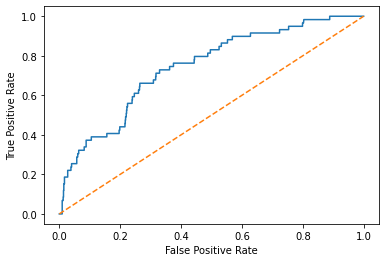

Area Under the Curve: 0.7434121652047045


In [78]:
y_score = lr_spec.decision_function(pred_test)
fpr, tpr, thresholds = roc_curve(purchase_test, y_score, pos_label=lr_spec.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

x = [0,1]
plt.plot(x,x,"--")
plt.show()

print("Area Under the Curve:",auc(fpr,tpr))


## Train/test splitting

In the exercise about `Caravan`, we split the full dataset into train/test partitions
by simply taking apart the 1st 1,000 rows and putting them in the test set.

While this is a quick & dirty approach, it is not the best.
In fact, doing so may introduce **bias** in the downstream analysis,
since the partition is definitely not random.

A better way is to randomly select the indices for train/test sets:
to do so, we'll use the function `train_test_split()`.
Remember to set the random state to get reproducible results.

Back to the Caravan data, here is a way to randomly split into train/test:

In [79]:

x_train, x_test, y_train, y_test = train_test_split(Caravan_scaled, dataf["Purchase"], test_size=1000, random_state=0)

knn_spec = KNeighborsClassifier(n_neighbors=3)
knn_spec.fit(x_train,y_train)
predictions = knn_spec.predict(x_test)

print("\nConfusion matrix for KNN(3):\n", confusion_matrix(predictions, y_test))
print("\nprecision in KNN(3):", precision_score(y_test,predictions,pos_label="Yes"))


Confusion matrix for KNN(3):
 [[916  64]
 [ 17   3]]

precision in KNN(3): 0.15


You can repeat the above using a different random seed: notice that you can get different results and that the accuracy of the positive class may not always increase with k.